# TF创建并训练CNN来进行图像分类

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


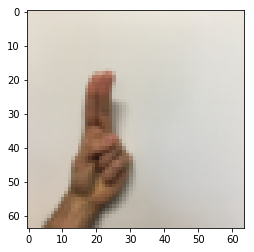

In [3]:
index = 10
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("训练样本数 = " + str(X_train.shape[0]))
print ("测试样本数 = " + str(X_test.shape[0]))
print ("X_train的维度: " + str(X_train.shape))
print ("Y_train的维度: " + str(Y_train.shape))
print ("X_test的维度: " + str(X_test.shape))
print ("Y_test的维度: " + str(Y_test.shape))
conv_layers = {}

训练样本数 = 1080
测试样本数 = 120
X_train的维度: (1080, 64, 64, 3)
Y_train的维度: (1080, 6)
X_test的维度: (120, 64, 64, 3)
Y_test的维度: (120, 6)


## 创建占位符（placeholder）

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    参数：
    n_H0 -- 图像矩阵的高
    n_W0 -- 图像矩阵的宽
    n_C0 -- 图像矩阵的深度
    n_y -- 标签类别数量，我们的数据集时0到5的手势，所以有6个类别
    
    返回值：
    X -- 样本数据的占位符
    Y -- 标签的占位符
    """
    
    #下面使用None来表示样本数量，表示当前还不确定样本数量
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    
    return X, Y

In [6]:
#单元测试
X, Y = create_placeholders(64,64,3,6)
print('X =' + str(X))
print('Y =' + str(Y))

X =Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y =Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


### 初始化参数

In [7]:
def initialize_parameters():
    
    tf.set_random_seed(1)
    
    #使用`tf.contrib.layers.xavier_initializer(seed = 0)`来初始化W1。
    #W1的维度时[4， 4，3，8]表示第一个卷积层过滤器矩阵的[高，宽，深度，个数]
    W1 = tf.get_variable('W1', [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    W2 = tf.get_variable('W2', [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    #注意，不初始化阈值b和全连接层的相关参数，因为TF会自动初始化它们
    
    parameters = {'W1' : W1, 'W2' : W2}
    
    return parameters

In [8]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [9]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()))
    print("W2 = " + str(parameters["W2"].eval()))

W1 = [[[[ 0.11547081 -0.15562162  0.14463945 -0.12213563 -0.161331
     0.0167321   0.00137798  0.15687598]
   [ 0.06261188  0.15809353 -0.13944083  0.1304368   0.14947264
     0.07770665 -0.0344099   0.02789916]
   [ 0.1310067   0.03547595  0.1019934   0.17467071 -0.16157703
    -0.06069881 -0.10278072 -0.06633689]]

  [[-0.1701455  -0.15981087 -0.06383926 -0.00349012 -0.14234345
    -0.05761932  0.00821769 -0.07173218]
   [ 0.14097519  0.11141728  0.18437327  0.0588678  -0.13764857
    -0.11404216  0.05882488  0.09655331]
   [ 0.09364428 -0.03100704  0.16560768  0.14417745  0.15409656
    -0.08602516 -0.12028332 -0.16772161]]

  [[ 0.18019755 -0.17030357 -0.10018802 -0.18330556  0.03716455
    -0.09169444 -0.01606575 -0.10697315]
   [-0.1352132   0.04067522  0.07451691  0.02565144 -0.08935398
    -0.14955646  0.17125843 -0.10636543]
   [ 0.1641133  -0.16645104  0.14331098 -0.0984499  -0.02071032
    -0.13608913  0.15722917 -0.05736801]]

  [[ 0.18048044  0.12755601  0.09927674 -0.078

### 前向传播

In [10]:
def forward_propagation(X, parameters):
    """
    这个函数会实现如下的前向传播流程:
    CONV2D卷积 -> RELU激活 -> MAXPOOL池化 
    -> CONV2D卷积 -> RELU激活 -> MAXPOOL池化 
    -> FLATTEN扁平化 -> 全连接层 -> softmax
    
    参数：
    X -- 输入特征对占位符
    parameters -- 之前我们初始化好的‘W1’，‘W2’
    
    return：
    Z3 -- 最后一个全连接层的输出
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1 ,strides=[1, 1, 1, 1], padding = 'SAME')
    
    A1 = tf.nn.relu(Z1)
    
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides = [1, 8, 8, 1], padding = 'SAME')
    
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding = 'SAME')
    
    A2 = tf.nn.relu(Z2)
    
    P2 = tf.nn.max_pool(A2, ksize = [1, 4, 4, 1], strides = [1, 4, 4, 1], padding = 'SAME')
    
    P = tf.contrib.layers.flatten(P2)
    
    #指定该全连接层有6个神经元
    #activation_fn = None表示该层没有激活函数， 因为后面会再接一个softmax层
    Z3 = tf.contrib.layers.fully_connected(P, 6, activation_fn = None)

    return Z3

In [11]:
#单元测试
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2, 64, 64, 3), Y:np.random.randn(2,6)})
    print('Z3 =' + str(a))

Instructions for updating:
Use keras.layers.flatten instead.
Z3 =[[ 1.4416987  -0.24909692  5.450499   -0.2618962  -0.20669901  1.3654671 ]
 [ 1.4070845  -0.02573182  5.0892797  -0.4866991  -0.4094069   1.2624857 ]]


### 计算损失

In [12]:
def compute_cost(Z3, Y):
    """
    参数：
    Z3
    Y
    
    returns：
    cost -- 返回一个滕送染发咯哇张量，它代表量softmax激活以及成本计算操作
    """
    
    #tf.nn.softmax_cross_with_logits函数不仅仅执行了softmax函数，还将成本也给计算了
    #tf.reduce_mean 本用来获取平均值。再这里被用于获取多个样本的平均损失，即获取成本
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    
    return cost

In [13]:
#单元测试
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a =sess.run(cost, {X: np.random.randn(4, 64, 64, 3), Y: np.random.randn(4, 6)})
    print('cost = ' + str(a))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = 4.664871


## 模型构建

In [21]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.001,
          num_epochs=100, minibatch_size=64, print_cost=True):
    """
    参数:
    X_train -- 训练集数据，维度是(1080, 64, 64, 3)
    Y_train -- 训练集标签, 维度是(1080, 6)
    X_test -- 测试集数据, 维度是(120, 64, 64, 3)
    Y_test -- 测试集标签, 维度是(120, 6)
    
    返回值:
    train_accuracy -- 训练集上的预测精准度
    test_accuracy -- 测试集上的预测精准度
    parameters -- 训练好的参数
    """
    
    ops.reset_default_graph()                         # 重置一下tf框架
    tf.set_random_seed(1)                       
    seed = 3                                       
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]   # n_y是标签的类别数量，这里是6
    costs = []                                     
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    parameters = initialize_parameters()

    Z3 = forward_propagation(X, parameters)

    cost = compute_cost(Z3, Y)

    
    # 我们使用adam来作为优化算法
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                # 执行session。训练正式开始。每一次训练一个子训练集minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # 计算预测精准度
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("训练集预测精准度:", train_accuracy)
        print("测试集预测精准度:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.971088
Cost after epoch 5: 1.894473
Cost after epoch 10: 1.881714
Cost after epoch 15: 1.853389
Cost after epoch 20: 1.767419
Cost after epoch 25: 1.601678
Cost after epoch 30: 1.365254
Cost after epoch 35: 1.145214
Cost after epoch 40: 1.014459
Cost after epoch 45: 0.895421
Cost after epoch 50: 0.817803
Cost after epoch 55: 0.729975
Cost after epoch 60: 0.668969
Cost after epoch 65: 0.604105
Cost after epoch 70: 0.574317
Cost after epoch 75: 0.536932
Cost after epoch 80: 0.508335
Cost after epoch 85: 0.471849
Cost after epoch 90: 0.436079
Cost after epoch 95: 0.419138


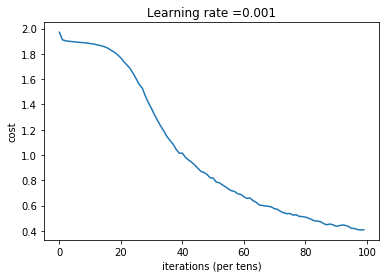

Tensor("Mean_1:0", shape=(), dtype=float32)
训练集预测精准度: 0.87222224
测试集预测精准度: 0.80833334


In [22]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

/Users/mac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


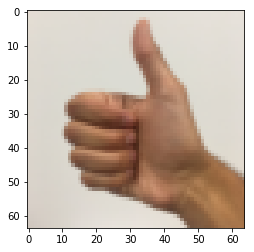

In [23]:
fname = "images/thumbs_up.jpg"
image = np.array(plt.imread(fname))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)